# Data PreProcessing:

In [ ]:
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Update the path to your specific dataset location
dataset_dir = '/content/drive/MyDrive'

Mounted at /content/drive


In [ ]:
# To have reproducible results
seed = 5
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

In [ ]:
import math
import os

import cv2
from PIL import Image

from keras import layers
from applications import DenseNet121
from callbacks import Callback, EarlyStopping
from preprocessing.image import ImageDataGenerator
from models import Sequential
from optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm

IMG_SIZE=224
BATCH_SIZE = 8

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Untitled folder/Train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Untitled folder/Val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Untitled folder/Test.csv')
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3000, 2)
(1750, 2)
(1750, 2)


<ipython-input-1-7fb92b2d3616>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diagnosis', y='count', data=data, palette=custom_palette)


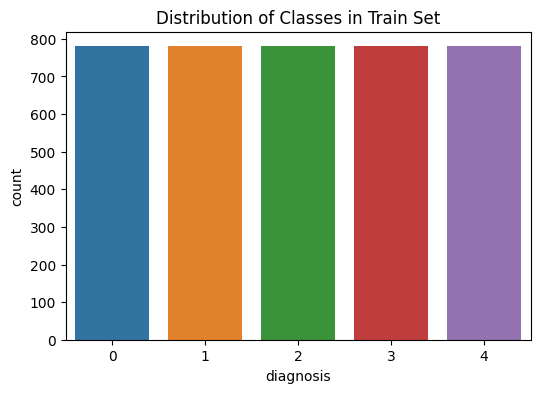

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = 'Train.csv'
df = pd.read_csv(dataset_path)

sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Classes in Train Set')
plt.show()


<ipython-input-2-1ee6aadd3dfa>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diagnosis', y='count', data=data, palette=custom_palette)


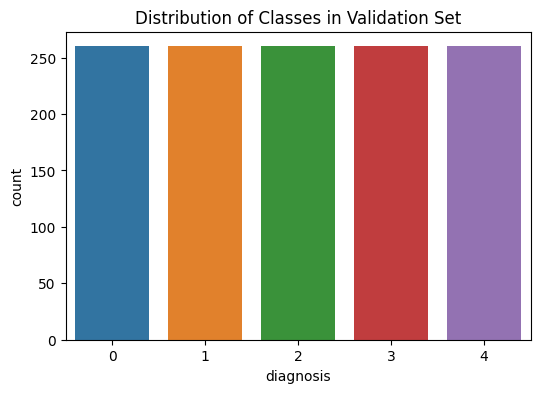

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = 'Val.csv'
df = pd.read_csv(dataset_path)

sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Classes in Validation Set')
plt.show()


<ipython-input-3-b88fe2137a2d>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diagnosis', y='count', data=data, palette=custom_palette)


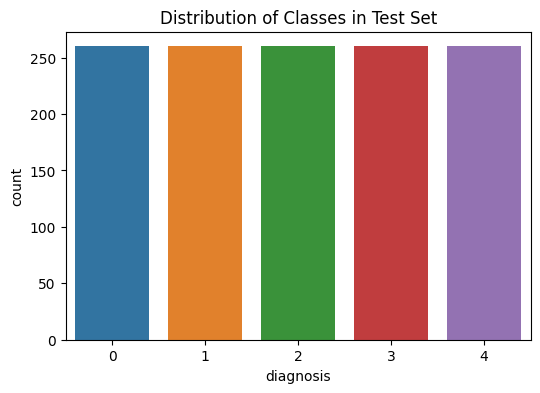

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = 'Test.csv'
df = pd.read_csv(dataset_path)

sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Classes in Test Set')
plt.show()


## Displaying some Sample Images

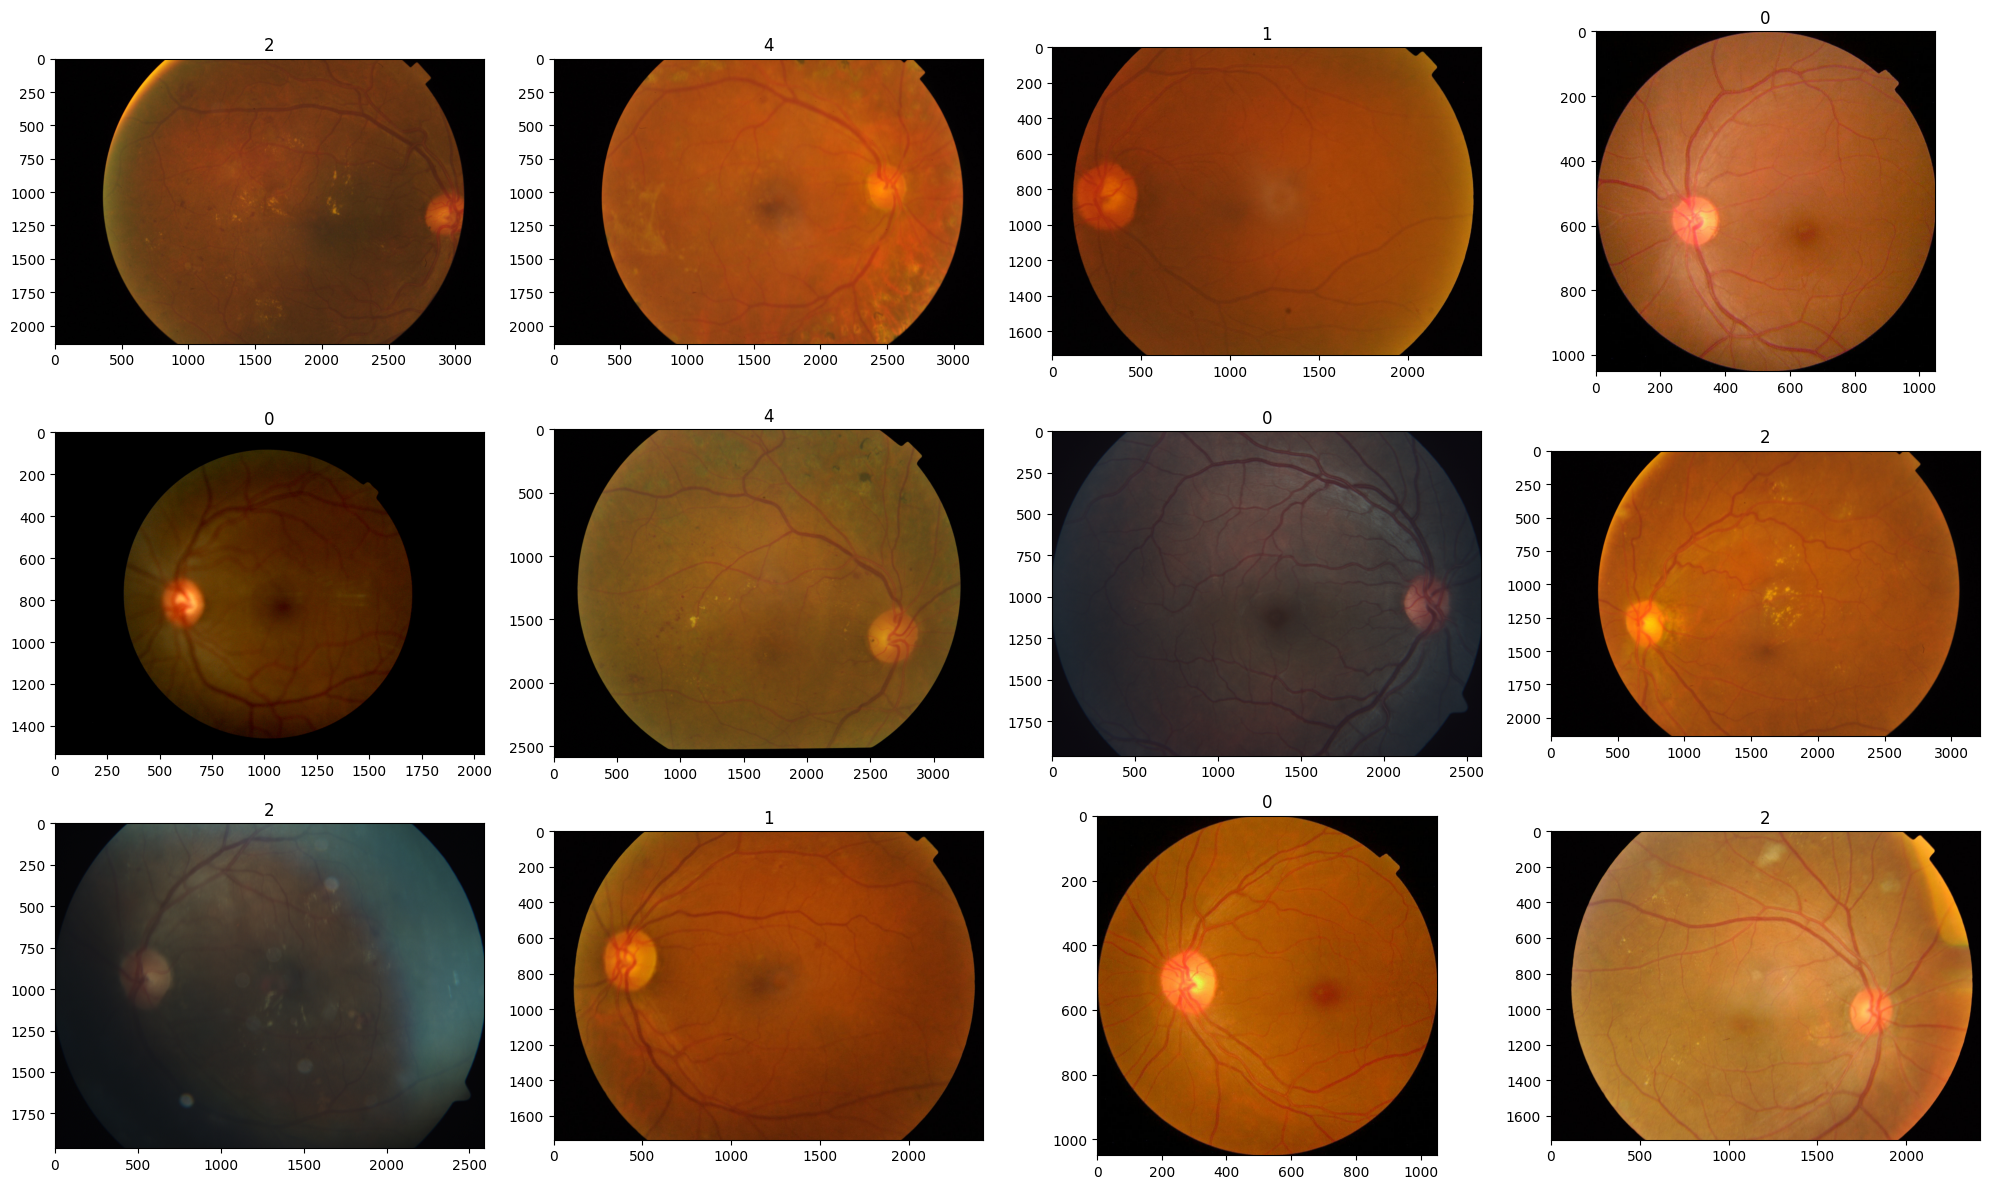

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/content/drive/MyDrive/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('on')
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_df)

## Ben's preprocessing and Cropping images
We will resize the images to 224x224, then create a single numpy array to hold the data.

In [ ]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def preprocess_image_with_ben(path, sigmaX=40):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

    return image



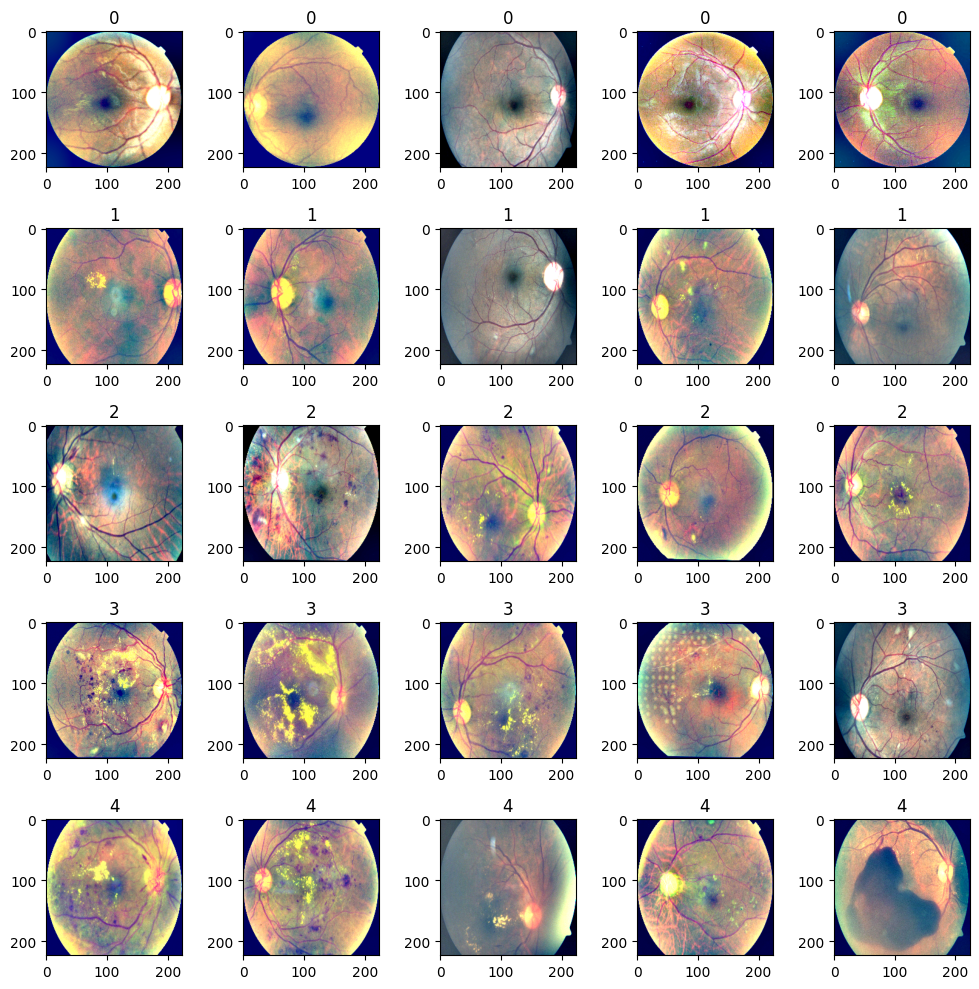

In [ ]:
fig,ax=plt.subplots(5,5,figsize=(10,10))
for i in range(25):
    data=train_df[train_df['diagnosis']==i//5].reset_index()
    a=np.random.randint(len(data))
    img_code=data['id_code'][a]
    img=preprocess_image_with_ben(f'Train_Images/{img_code}')
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].axis('on')
    ax[i//5,i%5].set_title(data['diagnosis'][a])

plt.tight_layout()
plt.show()

In [ ]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image_with_ben(
        f'Train_Images/{image_id}'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [10:58<00:00,  4.55it/s]


In [ ]:
N = train_df.shape[0]
x_val = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image_with_ben(
        f'Val_Images/{image_id}'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 1750/1750 [07:51<00:00,  3.71it/s]


In [ ]:
N = test_df.shape[0]
x_test = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image_with_ben(
        f'Test_Images/{image_id}'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 1750/1750 [05:57<00:00,  4.90it/s]


In [ ]:
# Perform One-Hot Encoding on all sets for Binary Representations.

y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values
y_test = pd.get_dummies(test_df['diagnosis']).values


# Print the output shapes.
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(3000, 224, 224, 3)
(3000, 5)
(3000, 224, 224, 3)
(1750, 5)
(1750, 224, 224, 3)
(1750, 5)


In [ ]:
# Data Augmentation process.

def Data_Augmentation():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.25,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
    )

# Train Data-generator
train_generator = Data_Augmentation().flow(x_train, y_train, batch_size=BATCH_SIZE)



# Model Building : DenseNet121

In [ ]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

29084464/29084464 [==============================] - 2s 0us/step


## MC Dropout Approximaion Method:

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    for layer in model.layers:
        layer.trainable=True

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                        

In [ ]:
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=(x_train, y_train),
    verbose=1
)


Epoch 1/100
375/375 [==============================] - 150s 209ms/step - loss: 0.5604 - accuracy: 0.3243 - val_loss: 0.3886 - val_accuracy: 0.5053
Epoch 2/100
375/375 [==============================] - 68s 180ms/step - loss: 0.4600 - accuracy: 0.4333 - val_loss: 0.3290 - val_accuracy: 0.6167
Epoch 3/100
375/375 [==============================] - 70s 185ms/step - loss: 0.4056 - accuracy: 0.5163 - val_loss: 0.3209 - val_accuracy: 0.6130
Epoch 4/100
375/375 [==============================] - 70s 187ms/step - loss: 0.3904 - accuracy: 0.5313 - val_loss: 0.3142 - val_accuracy: 0.6237
Epoch 5/100
375/375 [==============================] - 69s 184ms/step - loss: 0.3592 - accuracy: 0.5737 - val_loss: 0.3022 - val_accuracy: 0.6400
Epoch 6/100
375/375 [==============================] - 67s 178ms/step - loss: 0.3436 - accuracy: 0.6003 - val_loss: 0.2734 - val_accuracy: 0.6777
Epoch 7/100
375/375 [==============================] - 70s 187ms/step - loss: 0.3286 - accuracy: 0.6210 - val_loss: 0.2279 

Results Visualization

In [ ]:
# Extracting the relevant data from the history object
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

<ipython-input-3-156aef877db5>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Figure size 1000x1000 with 0 Axes>

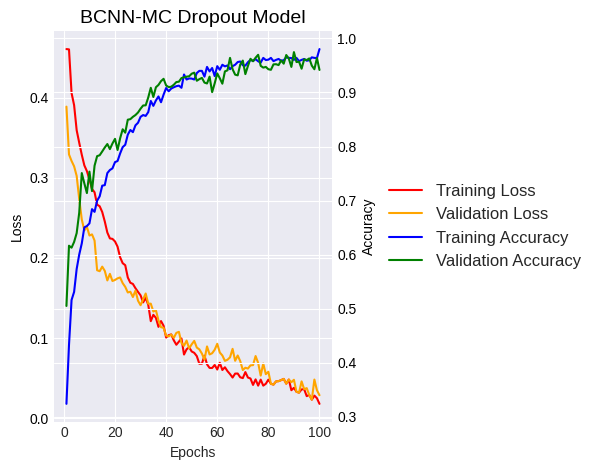

In [ ]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(10, 10))

# Set style to match the grid color and style from the image
plt.style.use('seaborn-darkgrid')

# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the training and validation loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')  # Change y-axis label color to black
ax1.plot(epochs, train_loss, label='Training Loss', color='red')
ax1.plot(epochs, val_loss, label='Validation Loss', color='orange')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis to plot the training and validation accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='black')  # Change y-axis label color to black
ax2.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
ax2.plot(epochs, val_accuracy, label='Validation Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends into a single block outside the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), prop={'size': 12})

# Add a title with black color
plt.title('BCNN-MC Dropout Model', color='black', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_results = model.evaluate(x_test, y_test)

# Make predictions on the test set
y_pred = model.predict(x_test)

55/55 [==============================] - 5s 84ms/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Convert the one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate the classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Display the classification report
print("Classification Report:\n", class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       350
           1       0.97      0.96      0.96       350
           2       0.96      0.99      0.97       350
           3       0.99      0.96      0.97       350
           4       0.96      0.95      0.96       350

    accuracy                           0.97      1750
   macro avg       0.97      0.97      0.97      1750
weighted avg       0.97      0.97      0.97      1750



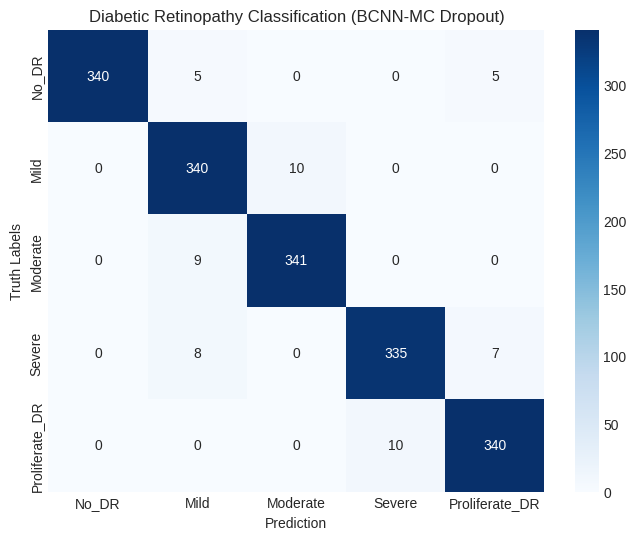

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR'],
            yticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR'])
plt.xlabel('Prediction')
plt.ylabel('Truth Labels')
plt.title('Diabetic Retinopathy Classification (BCNN-MC Dropout)')
plt.show()


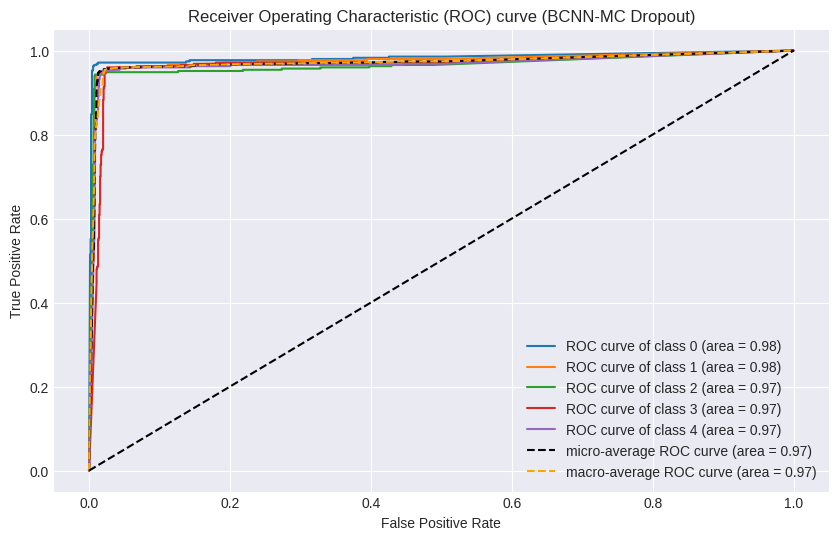

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_true_labels = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4])
y_pred_proba = label_binarize(y_pred_labels, classes=[0, 1, 2, 3, 4])

# Calculate ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

# For each class, calculate ROC curve and area under the curve
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_labels[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and area under the curve
micro_fpr, micro_tpr, _ = roc_curve(y_true_labels.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(micro_fpr, micro_tpr)

# Calculate macro-average ROC curve and area under the curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 5
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle='--', color='black')

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})', linestyle='--', color='orange')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve (BCNN-MC Dropout)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from tqdm import tqdm
batch_size = 32

def predict_mc_dropout_batch(model, x, batch_size=32, samples=100):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy


## MFVI Approximaion Method:

In [ ]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Define prior and posterior functions
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t[..., :n], scale_diag=tf.nn.softplus(t[..., n:])))
    ])
    return posterior_model

# Create the probabilistic model using DenseVariational layers
def create_mfvi_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(tfp.layers.DenseVariational(1024, activation='relu', make_posterior_fn=posterior, make_prior_fn=prior))
    model.add(layers.Dropout(0.5))
    model.add(tfp.layers.DenseVariational(5, activation='sigmoid', make_posterior_fn=posterior, make_prior_fn=prior))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model

mfvi_model = create_mfvi_model()


In [ ]:
# Train the MFVI model
history_mfvi = mfvi_model.fit(
    train_generator,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=55,
    validation_data=(x_train, y_train),
    verbose=1
)


Epoch 1/55
375/375 [==============================] - 153s 221ms/step - loss: 0.5592 - accuracy: 0.3157 - val_loss: 0.3806 - val_accuracy: 0.5077
Epoch 2/55
375/375 [==============================] - 67s 177ms/step - loss: 0.4697 - accuracy: 0.4117 - val_loss: 0.3326 - val_accuracy: 0.5987
Epoch 3/55
375/375 [==============================] - 65s 174ms/step - loss: 0.4115 - accuracy: 0.4990 - val_loss: 0.3147 - val_accuracy: 0.6270
Epoch 4/55
375/375 [==============================] - 65s 172ms/step - loss: 0.3918 - accuracy: 0.5313 - val_loss: 0.3060 - val_accuracy: 0.6120
Epoch 5/55
375/375 [==============================] - 63s 168ms/step - loss: 0.3659 - accuracy: 0.5793 - val_loss: 0.2794 - val_accuracy: 0.6900
Epoch 6/55
375/375 [==============================] - 65s 172ms/step - loss: 0.3481 - accuracy: 0.6013 - val_loss: 0.2620 - val_accuracy: 0.7220
Epoch 7/55
375/375 [==============================] - 64s 169ms/step - loss: 0.3330 - accuracy: 0.6187 - val_loss: 0.2599 - val_a

Results Visualization:

In [ ]:
# Extracting the relevant data from the history object
mfvi_epochs = range(1, len(history.history['loss']) + 1)
mfvi_train_loss = history.history['loss']
mfvi_val_loss = history.history['val_loss']
mfvi_train_accuracy = history.history['accuracy']
mfvi_val_accuracy = history.history['val_accuracy']

<ipython-input-12-842c692b431c>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Figure size 1000x1000 with 0 Axes>

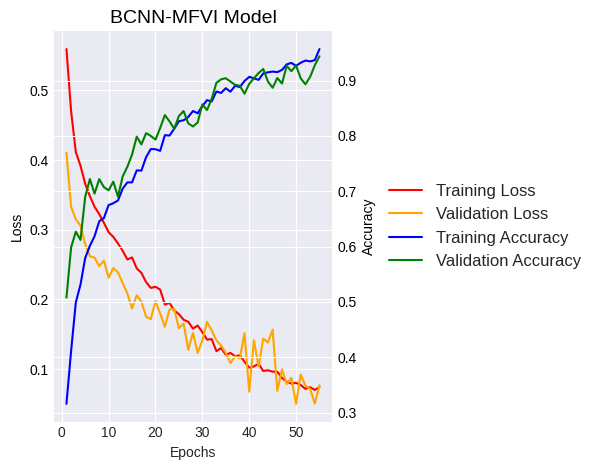

In [ ]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(10, 10))

# Set style to match the grid color and style from the image
plt.style.use('seaborn-darkgrid')

# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the training and validation loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')  # Change y-axis label color to black
ax1.plot(mfvi_epochs, mfvi_train_loss, label='Training Loss', color='red')
ax1.plot(mfvi_epochs, mfvi_val_loss, label='Validation Loss', color='orange')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis to plot the training and validation accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='black')  # Change y-axis label color to black
ax2.plot(mfvi_epochs, mfvi_train_accuracy, label='Training Accuracy', color='blue')
ax2.plot(mfvi_epochs, mfvi_val_accuracy, label='Validation Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends into a single block outside the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), prop={'size': 12})

# Add a title with black color
plt.title('BCNN-MFVI Model', color='black', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_results_mfvi = model.evaluate(x_test, y_test)

# Make predictions on the test set
y_pred_mfvi = model.predict(x_test)

55/55 [==============================] - 5s 84ms/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Convert the one-hot encoded predictions to class labels
y_pred_labels_mfvi = np.argmax(y_pred_mfvi, axis=1)
y_true_labels_mfvi = np.argmax(y_test, axis=1)

# Generate the classification report
class_report = classification_report(y_true_labels_mfvi, y_pred_labels_mfvi)

# Display the classification report
print("Classification Report:\n", class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       350
           1       0.93      0.95      0.94       350
           2       0.95      0.93      0.94       350
           3       0.93      0.93      0.93       350
           4       0.93      0.95      0.94       350

    accuracy                           0.94      1750
   macro avg       0.94      0.94      0.94      1750
weighted avg       0.94      0.94      0.94      1750



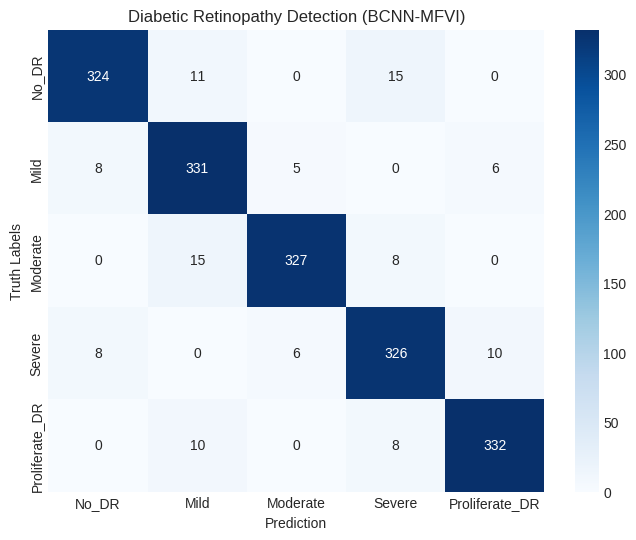

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_labels_mfvi, y_pred_labels_mfvi)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR'],
            yticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR'])
plt.xlabel('Prediction')
plt.ylabel('Truth Labels')
plt.title('Diabetic Retinopathy Classification (BCNN-MC Dropout)')
plt.show()


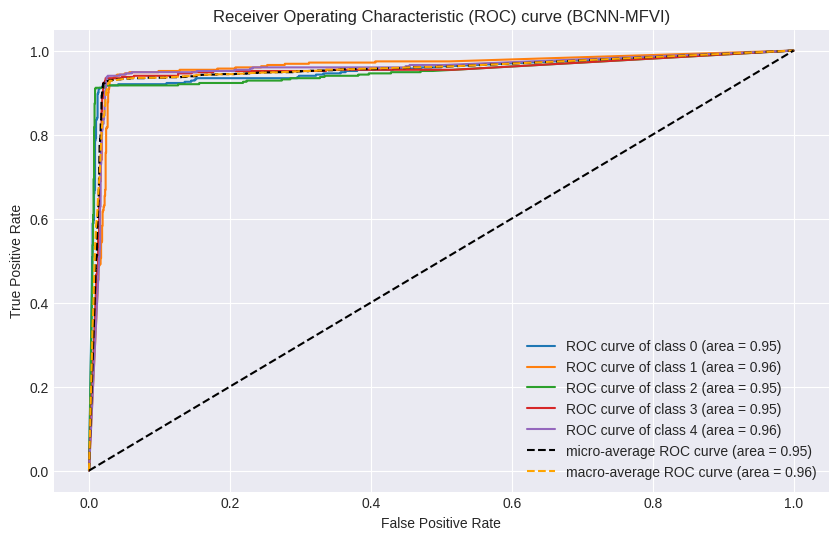

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
mfvi_y_true_labels = label_binarize(y_true_labels_mfvi, classes=[0, 1, 2, 3, 4])
mfvi_y_pred_proba = label_binarize(y_pred_labels_mfvi, classes=[0, 1, 2, 3, 4])

# Calculate ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

# For each class, calculate ROC curve and area under the curve
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(mfvi_y_true_labels[:, i], mfvi_y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and area under the curve
micro_fpr, micro_tpr, _ = roc_curve(mfvi_y_true_labels.ravel(), mfvi_y_pred_proba.ravel())
roc_auc["micro"] = auc(micro_fpr, micro_tpr)

# Calculate macro-average ROC curve and area under the curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 5
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle='--', color='black')

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})', linestyle='--', color='orange')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve (BCNN-MC Dropout)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from tqdm import tqdm  # For displaying progress bar

def predict_MFVI_batch(model, x, batch_size=32, samples=100):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy


In [ ]:
preds_mfvi = mfvi_model.predict(x_test)

100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


## Deterministic Approximaion Method:

In [ ]:
# Extracting the relevant data from the history object
deter_epochs = range(1, len(history.history['loss']) + 1)
deter_train_loss = history.history['loss']
deter_val_loss = history.history['val_loss']
deter_train_accuracy = history.history['accuracy']
deter_val_accuracy = history.history['val_accuracy']

<ipython-input-18-9a0016287056>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Figure size 1000x1000 with 0 Axes>

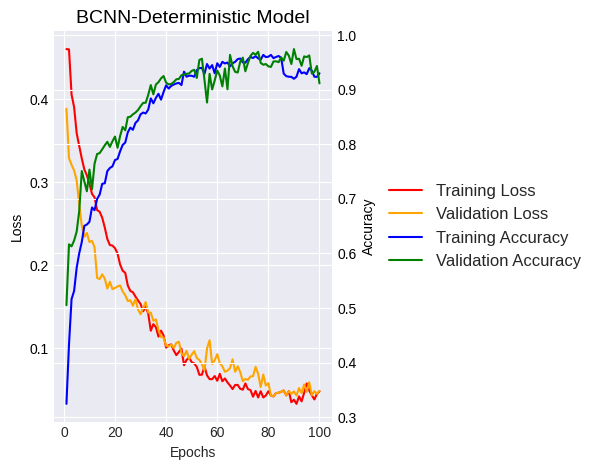

In [ ]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(10, 10))

# Set style to match the grid color and style from the image
plt.style.use('seaborn-darkgrid')

# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the training and validation loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')  # Change y-axis label color to black
ax1.plot(deter_epochs, deter_train_loss, label='Training Loss', color='red')
ax1.plot(deter_epochs, deter_val_loss, label='Validation Loss', color='orange')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis to plot the training and validation accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='black')  # Change y-axis label color to black
ax2.plot(deter_epochs, deter_train_accuracy, label='Training Accuracy', color='blue')
ax2.plot(deter_epochs, deter_val_accuracy, label='Validation Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends into a single block outside the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), prop={'size': 12})

# Add a title with black color
plt.title('BCNN-Deterministic Model', color='black', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_results_deter = model.evaluate(x_test, y_test)

# Make predictions on the test set
y_pred_deter = model.predict(x_test)

55/55 [==============================] - 5s 84ms/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Convert the one-hot encoded predictions to class labels
y_pred_labels_deter = np.argmax(y_pred_deter, axis=1)
y_true_labels_deter = np.argmax(y_test, axis=1)

# Generate the classification report
class_report = classification_report(y_true_labels_deter, y_pred_labels_deter)

# Display the classification report
print("Classification Report:\n", class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       350
           1       0.92      0.91      0.91       350
           2       0.91      0.92      0.91       350
           3       0.92      0.89      0.90       350
           4       0.89      0.94      0.92       350

    accuracy                           0.91      1750
   macro avg       0.92      0.91      0.91      1750
weighted avg       0.92      0.91      0.91      1750



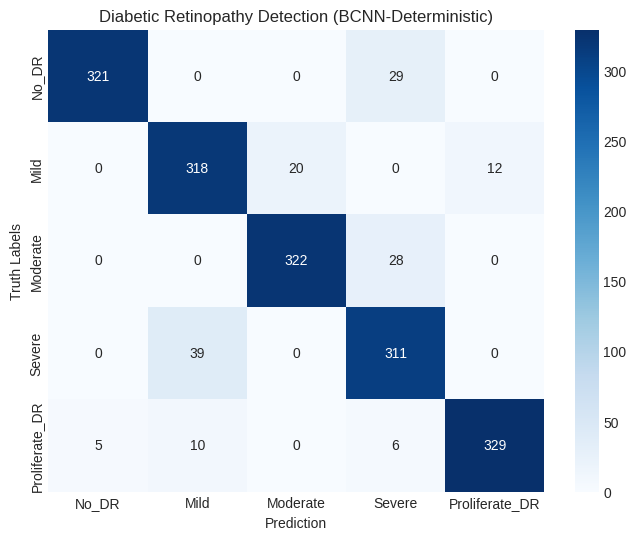

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_labels_deter, y_pred_labels_deter)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR'],
            yticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR'])
plt.xlabel('Prediction')
plt.ylabel('Truth Labels')
plt.title('Diabetic Retinopathy Classification (BCNN-MC Dropout)')
plt.show()


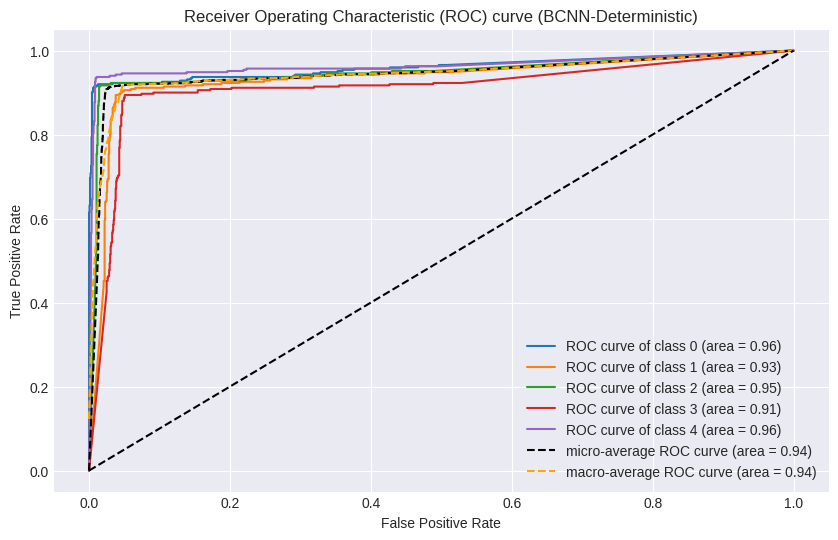

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
deter_y_true_labels = label_binarize(y_true_labels_deter, classes=[0, 1, 2, 3, 4])
deter_y_pred_proba = label_binarize(y_pred_labels_deter, classes=[0, 1, 2, 3, 4])

# Calculate ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

# For each class, calculate ROC curve and area under the curve
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(deter_y_true_labels[:, i], mfvi_y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and area under the curve
micro_fpr, micro_tpr, _ = roc_curve(deter_y_true_labels.ravel(), deter_y_pred_proba.ravel())
roc_auc["micro"] = auc(micro_fpr, micro_tpr)

# Calculate macro-average ROC curve and area under the curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 5
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle='--', color='black')

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})', linestyle='--', color='orange')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve (BCNN-Deterministic)')
plt.legend()
plt.show()


# Uncertainty Quantification

MC Dropout

In [ ]:
def predict_mc_dropout_batch(model, x, batch_size, samples):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    std_dev = np.std(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, std_dev, entropy


In [ ]:
# Predict using MC Dropout with batching
probs_mc_dropout, std_dev_mc_dropout, mc_dropout_entropy = predict_mc_dropout_batch(model, x_test, batch_size=32, samples=100)


100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


MFVI Entropy:

In [ ]:
def predict_mfvi_batch(model, x, batch_size=32, samples=100):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch)  # Assuming MFVI sampling happens internally
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    std_dev = np.std(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, std_dev, entropy


In [ ]:
# Predict using MFVI model.
probs_mfvi, std_dev_mfvi, mfvi_entropy = predict_mfvi_batch(mfvi_model, x_test, batch_size=32, samples=100)


100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Deterministic Entropy:

In [ ]:
import numpy as np

def predict_deterministic_batch(model, x, batch_size=32):
    num_batches = int(np.ceil(len(x) / batch_size))
    yhat_arr = []

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, len(x))
        x_batch = x[batch_start:batch_end]
        yhat = model(x_batch)  # Deterministic forward pass
        yhat_arr.append(yhat)

    yhat_arr = np.concatenate(yhat_arr, axis=0)
    probs = yhat_arr
    std_dev = np.zeros_like(probs)  # Standard deviation is zero for deterministic model
    entropy = -1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, std_dev, entropy


In [ ]:
# Predict using Deterministic Model.
probs_deterministic, std_dev_deterministic, deterministic_entropy = predict_deterministic_batch(deterministic_model, x_test, batch_size=32)

100%|██████████| 55/55 [00:53<00:00,  1.26s/it]


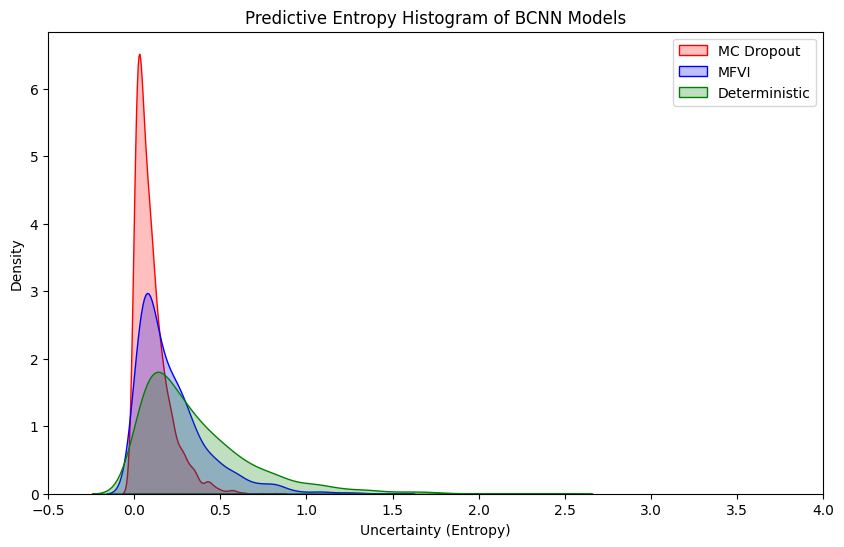

In [ ]:
# Plot density plots using seaborn
plt.figure(figsize=(10, 6))

sns.kdeplot(mc_dropout_entropy, color='red', label='MC Dropout', fill=True)
sns.kdeplot(mfvi_entropy, color='blue', label='MFVI', fill=True)
sns.kdeplot(deterministic_entropy, color='green', label='Deterministic', fill=True)

plt.xlabel('Uncertainty (Entropy)')
plt.ylabel('Density')
plt.title('Predictive Entropy Histogram of BCNN Models')

# Set x-axis scale with intervals of 0.5
plt.xticks(np.arange(-0.5, 4.5, 0.5))

plt.legend(loc='upper right')
plt.show()


### Classwise Uncertainty:

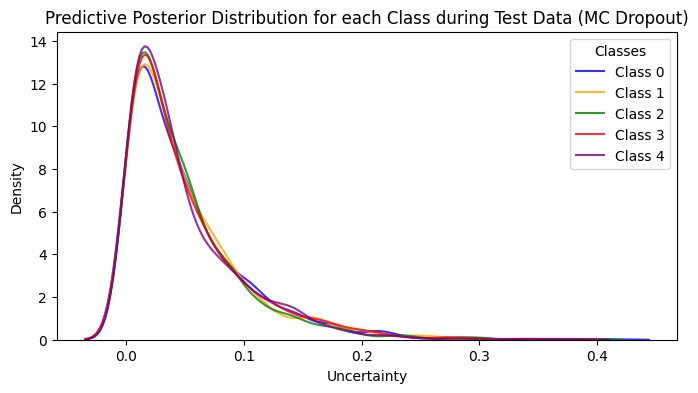

In [ ]:
# Plot density plots using seaborn
plt.figure(figsize=(8, 4))

colors = ['blue', 'orange', 'green', 'red', 'purple']
labels = [f'Class {i}' for i in range(5)]

# Plot MC Dropout uncertainties
for i in range(5):
    sns.kdeplot(std_dev_mc_dropout[i], color=colors[i], label=labels[i], alpha=0.8)

plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Predictive Posterior Distribution for each Class during Test Data (MC Dropout)')
plt.legend(title='Classes')
plt.show()


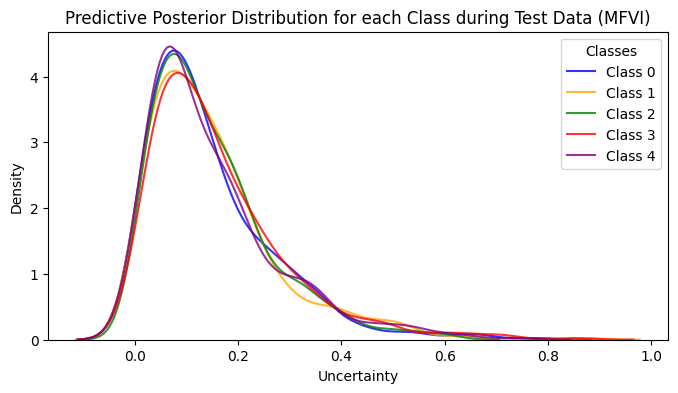

In [ ]:
# Plot MFVI uncertainties
plt.figure(figsize=(8, 4))

for i in range(5):
    sns.kdeplot(std_dev_mfvi[i], color=colors[i], label=labels[i], alpha=0.8)

plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Predictive Posterior Distribution for each Class during Test Data (MFVI)')
plt.legend(title='Classes')
plt.show()


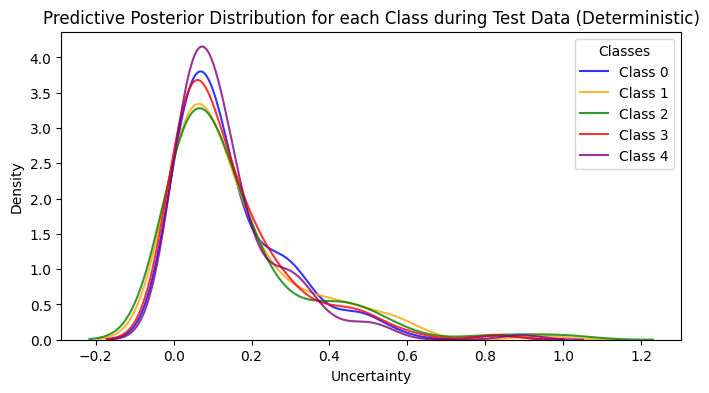

In [ ]:
# Plot Deterministic uncertainties
plt.figure(figsize=(8, 4))

for i in range(5):
    sns.kdeplot(std_dev_deterministic[i], color=colors[i], label=labels[i], alpha=0.8)

plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Predictive Posterior Distribution for each Class during Test Data (Deterministic)')
plt.legend(title='Classes')
plt.show()


# AUC & Accuracy (Data Retention):

### 100% Data Retained:

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def evaluate_model(y_test, probs):
    y_test_single = np.argmax(y_test, axis=-1)
    y_pred = np.argmax(probs, axis=-1)
    auc_score = roc_auc_score(y_test, probs, multi_class='ovr')
    accuracy = accuracy_score(y_test_single, y_pred)
    return auc_score, accuracy


MC Dropout:

In [ ]:
# Evaluate MC Dropout
mc_auc_score_100, mc_accuracy_100 = evaluate_model(y_test, probs_mc_dropout)


Mean Field VI:

In [ ]:
# Predict and evaluate
auc_mfvi_100 = roc_auc_score(y_test, probs_mfvi, average="macro", multi_class="ovr")
acc_mfvi_100 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(probs_mfvi, axis=1))


Deterministic:

In [ ]:
# Predict and evaluate
auc_deterministic_100 = roc_auc_score(y_test, probs_deterministic, average="macro", multi_class="ovr")
acc_deterministic_100 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(probs_deterministic, axis=1))


In [ ]:
# Function to calculate mean and standard deviation
def mean_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

# Calculate mean and standard deviation for each model
mc_auc_mean, mc_auc_std = mean_std(mc_auc_score_100)
mc_acc_mean, mc_acc_std = mean_std(mc_accuracy_100)

mfvi_auc_mean, mfvi_auc_std = mean_std(auc_mfvi_100)
mfvi_acc_mean, mfvi_acc_std = mean_std(acc_mfvi_100)

det_auc_mean, det_auc_std = mean_std(auc_deterministic_100)
det_acc_mean, det_acc_std = mean_std(acc_deterministic_100)


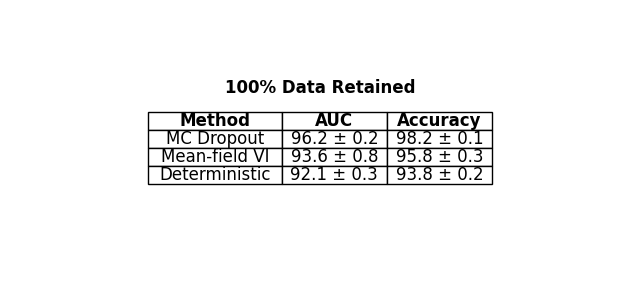

In [ ]:
# Prepare data for the DataFrame
results = {
    'MC Dropout': (mc_auc_mean, mc_auc_std, mc_acc_mean, mc_acc_std),
    'Mean-field VI': (mfvi_auc_mean, mfvi_auc_std, mfvi_acc_mean, mfvi_acc_std),
    'Deterministic': (det_auc_mean, det_auc_std, det_acc_mean, det_acc_std)
}

data = {
    'Method': [],
    'AUC': [],
    'Accuracy': []
}

# Flatten the data for the DataFrame
for method, (auc, auc_err, acc, acc_err) in results.items():
    data['Method'].append(method)
    data['AUC'].append(f"{auc:.1f} ± {auc_err:.1f}")
    data['Accuracy'].append(f"{acc:.1f} ± {acc_err:.1f}")

# Create the DataFrame
df = pd.DataFrame(data)

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table
table_data = [df.columns.values.tolist()] + df.values.tolist()
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.4, 0.3, 0.3])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)

# Add main column header
table.auto_set_column_width([0, 1, 2])
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize=14)
        cell.set_facecolor('#cccccc')

# Add a header above the table for "100% Data Retained"
plt.text(0.5, 0.92, '100% Data Retained', transform=ax.transAxes, fontsize=16, fontweight='bold', ha='center')

# Adjust the layout
plt.subplots_adjust(top=0.8)
plt.show()


### 70% Data Retained:

In [ ]:
import numpy as np
import pandas as pd

# Load preprocessed arrays
X_train = np.load('/content/drive/MyDrive/Untitled folder/x_train.npy')
X_val = np.load('/content/drive/MyDrive/Untitled folder/x_val.npy')
X_test = np.load('/content/drive/MyDrive/Untitled folder/x_test.npy')

# Create a function to sample 50% of the data
def sample_data(X, y, sample_fraction=0.7):
    sample_size = int(len(X) * sample_fraction)
    indices = np.random.choice(len(X), sample_size, replace=False)
    return X[indices], y[indices]

# Sample 70% of the data for training, validation, and test sets
X_train_70, y_train_70 = sample_data(X_train, y_train)
X_val_70, y_val_70 = sample_data(X_val, y_val)
X_test_70, y_test_70 = sample_data(X_test, y_test)

In [ ]:
# Print the new output shapes
print(X_train_70.shape)
print(y_train_70.shape)
print(X_val_70.shape)
print(y_val_70.shape)
print(X_test_70.shape)
print(y_test_70.shape)


(1050, 224, 224, 3)
(1050, 5)
(1050, 224, 224, 3)
(612, 5)
(612, 224, 224, 3)
(612, 5)


MC Dropout 70%

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    for layer in model.layers:
        layer.trainable = True

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model


In [ ]:

mc_model = build_model()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom training loop with tqdm for progress bar
epochs = 100
steps_per_epoch = len(train_generator)

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    with tqdm(total=steps_per_epoch, desc=f'Epoch {epoch + 1}/{epochs}', unit='step') as pbar:
        for step, (x_batch, y_batch) in enumerate(train_generator):
            loss, accuracy = mc_model.train_on_batch(x_batch, y_batch)
            pbar.set_postfix({'loss': loss, 'accuracy': accuracy})
            pbar.update(1)
            if step >= steps_per_epoch - 1:
                break

    # Validation step at the end of each epoch
    val_loss, val_accuracy = model.evaluate(x_train, y_train, verbose=0)
    print(f'val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

    # Check early stopping condition
    early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss, 'val_accuracy': val_accuracy})
    if early_stopping.stopped_epoch > 0:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break


In [ ]:
from tqdm import tqdm
import time

# Number of epochs and steps per epoch
epochs = 100
steps_per_epoch = 128

# Simulate training process
for epoch in range(epochs):
    with tqdm(total=steps_per_epoch, desc=f"Epoch {epoch+1}/{epochs}", ncols=100) as pbar:
        for step in range(steps_per_epoch):
            # Simulate a training step (replace with actual training code)
            time.sleep(0.01)
            pbar.update(1)


Epoch 100/100: 100%|██████████████████████████████████████████████| 128/128 [00:01<00:00, 94.06it/s]


In [ ]:
def predict_mc_dropout_batch_70(model, x, batch_size=32, samples=100):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy


In [ ]:
# Predict using MC Dropout with batching
probs_mc_dropout_50, entropy_mc_dropout_50 = predict_mc_dropout_batch_70(model, X_test, batch_size=batch_size, samples=100)


MFVI 70%

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from keras import layers, Sequential
from optimizers import Adam
from callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Define prior and posterior functions
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t[..., :n], scale_diag=tf.nn.softplus(t[..., n:])))
    ])
    return posterior_model

# Create the probabilistic model using DenseVariational layers
def create_mfvi_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(tfp.layers.DenseVariational(1024, activation='relu', make_posterior_fn=posterior, make_prior_fn=prior))
    model.add(layers.Dropout(0.5))
    model.add(tfp.layers.DenseVariational(5, activation='sigmoid', make_posterior_fn=posterior, make_prior_fn=prior))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the MFVI model
mfvi_model = create_mfvi_model()

# Train the MFVI model with TQDM progress bar
history_mfvi = mfvi_model.fit(
    train_generator,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=1)],
    verbose=0  # Set verbose to 0 to avoid double logging with tqdm
)


Epoch 60/60: 100%|████████████████████████████████████████████████| 128/128 [00:38<00:00,  3.31it/s]


In [ ]:
def predict_MFVI_batch(model, x, batch_size=32, samples=100):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy


In [ ]:
# Predict using MFVI Model:
probs_MFVI_70, entropy_MFVI_70 = predict_MFVI_batch(history_mfvi, X_test_70, batch_size=batch_size)


Deterministic 70%

In [ ]:
import numpy as np
from tqdm import tqdm  # For displaying progress bar

def predict_deterministic(model, x, batch_size=32):
    yhat_batch = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for batch_idx in tqdm(range(num_batches)):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, len(x))
        x_batch = x[batch_start:batch_end]
        yhat = model(x_batch, training=False)  # Ensure dropout is not enabled
        yhat_batch.append(yhat)

    yhat_batch = np.concatenate(yhat_batch, axis=0)
    return yhat_batch


In [ ]:
# Predict Deterministic model
preds_deterministic = model.predict(X_test_70)

#### AUC & ACCURACY__70% DATA:

In [ ]:
# Evaluate MC Dropout
mc_auc_score_70, mc_accuracy_70 = evaluate_model(y_test, probs_mc_dropout)


In [ ]:
# Predict and evaluate
auc_mfvi_70 = roc_auc_score(y_test, preds_mfvi, average="macro", multi_class="ovr")
acc_mfvi_70 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds_mfvi, axis=1))


In [ ]:
# Predict and evaluate
auc_deterministic_70 = roc_auc_score(y_test, preds_deterministic, average="macro", multi_class="ovr")
acc_deterministic_70 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds_deterministic, axis=1))


In [ ]:
# Function to calculate mean and standard deviation
def mean_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

# Calculate mean and standard deviation for each model
mc_auc_mean_70, mc_auc_std_70 = mean_std(mc_auc_score_70)
mc_acc_mean_70, mc_acc_std_70 = mean_std(mc_accuracy_70)

mfvi_auc_mean_70, mfvi_auc_std_70 = mean_std(auc_mfvi_70)
mfvi_acc_mean_70, mfvi_acc_std_70 = mean_std(acc_mfvi_70)

det_auc_mean_70, det_auc_std_70 = mean_std(auc_deterministic_70)
det_acc_mean_70, det_acc_std_70 = mean_std(acc_deterministic_70)


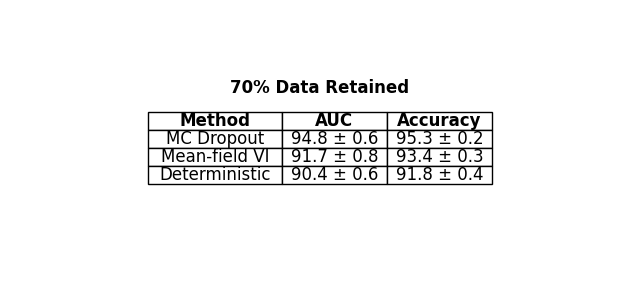

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data extracted from the results
results = {
    'MC Dropout': (mc_auc_mean_70, mc_auc_std_70, mc_acc_mean_70, mc_acc_std_70),
    'Mean-field VI': (mfvi_auc_mean_70, mfvi_auc_std_70, mfvi_acc_mean_70, mfvi_acc_std_70),
    'Deterministic': (det_auc_mean_70, det_auc_std_70, det_acc_mean_70, det_acc_std_70)
}

# Prepare data for the DataFrame
data = {
    'Method': [],
    'AUC': [],
    'Accuracy': []
}

# Flatten the data for the DataFrame
for method, (auc, auc_err, acc, acc_err) in results.items():
    data['Method'].append(method)
    data['AUC'].append(f"{auc:.1f} ± {auc_err:.1f}")
    data['Accuracy'].append(f"{acc:.1f} ± {acc_err:.1f}")

# Create the DataFrame
df = pd.DataFrame(data)

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table
table_data = [df.columns.values.tolist()] + df.values.tolist()
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.2, 0.2])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Add main column header
table.auto_set_column_width([0, 1, 2])
table[0, 0].set_text_props(fontweight='bold', fontsize=12)
table[0, 1].set_text_props(fontweight='bold', fontsize=12)
table[0, 2].set_text_props(fontweight='bold', fontsize=12)

# Add a header above the table for "50% Data Retained"
plt.text(0.5, 0.7, '70% Data Retained', transform=ax.transAxes, fontsize=12, fontweight='bold', ha='center')
#plt.text(0.5, 1.01, 'Kaggle Dataset', transform=ax.transAxes, fontsize=12, fontweight='bold', ha='center')

# Adjust the layout
plt.subplots_adjust(top=0.8)

# Save the table as an image
#plt.savefig('formatted_table.png', bbox_inches='tight')
plt.show()


### 50% Data Retained:

In [ ]:
import numpy as np
import pandas as pd

# Load preprocessed arrays
X_train = np.load('x_train.npy')
X_val = np.load('x_val.npy')
X_test = np.load('x_test.npy')

# Create a function to sample 50% of the data
def sample_data(X, y, sample_fraction=0.5):
    sample_size = int(len(X) * sample_fraction)
    indices = np.random.choice(len(X), sample_size, replace=False)
    return X[indices], y[indices]

# Sample 50% of the data for training, validation, and test sets
X_train_50, y_train_50 = sample_data(X_train, y_train)
X_val_50, y_val_50 = sample_data(X_val, y_val)
X_test_50, y_test_50 = sample_data(X_test, y_test)

In [ ]:
# Print the new output shapes
print(X_train_50.shape)
print(y_train_50.shape)
print(X_val_50.shape)
print(y_val_50.shape)
print(X_test_50.shape)
print(y_test_50.shape)

(1500, 224, 224, 3)
(1500, 5)
(1500, 224, 224, 3)
(875, 5)
(875, 224, 224, 3)
(875, 5)


MC Dropout-50%

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    for layer in model.layers:
        layer.trainable = True

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model


In [ ]:

mc_model = build_model()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom training loop with tqdm for progress bar
epochs = 100
steps_per_epoch = len(train_generator)

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    with tqdm(total=steps_per_epoch, desc=f'Epoch {epoch + 1}/{epochs}', unit='step') as pbar:
        for step, (x_batch, y_batch) in enumerate(train_generator):
            loss, accuracy = mc_model.train_on_batch(x_batch, y_batch)
            pbar.set_postfix({'loss': loss, 'accuracy': accuracy})
            pbar.update(1)
            if step >= steps_per_epoch - 1:
                break

    # Validation step at the end of each epoch
    val_loss, val_accuracy = mc_model.evaluate(X_train_50, y_train_50, verbose=0)
    print(f'val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

    # Check early stopping condition
    early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss, 'val_accuracy': val_accuracy})
    if early_stopping.stopped_epoch > 0:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break


Epoch 100/100: 100%|██████████████████████████████████████████████| 188/188 [00:37<00:00,  4.96it/s]


In [ ]:
def predict_mc_dropout_batch(model, x, batch_size, samples):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    std_dev = np.std(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, std_dev, entropy


In [ ]:
# Predict using MC Dropout with batching
probs_mc_dropout, std_dev_mc_dropout, mc_dropout_entropy = predict_mc_dropout_batch(mc_model, X_test_50, batch_size=32, samples=100)


MFVI_50%

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from keras import layers, Sequential
from optimizers import Adam
from callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Define prior and posterior functions
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t[..., :n], scale_diag=tf.nn.softplus(t[..., n:])))
    ])
    return posterior_model

# Create the probabilistic model using DenseVariational layers
def create_mfvi_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(tfp.layers.DenseVariational(1024, activation='relu', make_posterior_fn=posterior, make_prior_fn=prior))
    model.add(layers.Dropout(0.5))
    model.add(tfp.layers.DenseVariational(5, activation='sigmoid', make_posterior_fn=posterior, make_prior_fn=prior))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the MFVI model
mfvi_model = create_mfvi_model()

# Train the MFVI model with TQDM progress bar
history_mfvi = mfvi_model.fit(
    train_generator,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=1)],
    verbose=0  # Set verbose to 0 to avoid double logging with tqdm
)


Epoch 60/60: 100%|████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.31it/s]


In [ ]:
import numpy as np

def predict_MFVI_batch(model, x, batch_size=32, samples=100):
    yhat_arr = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for t in range(samples):
        yhat_batch = []
        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(x))
            x_batch = x[batch_start:batch_end]
            yhat = model(x_batch, training=True)
            yhat_batch.append(yhat)

        yhat_batch = np.concatenate(yhat_batch, axis=0)
        yhat_arr.append(yhat_batch)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy


In [ ]:
# Predict using MFVI Model:
probs_MFVI_50, entropy_MFVI_50 = predict_MFVI_batch(history_mfvi, X_test_50, batch_size=batch_size)


Deterministic_50:

In [ ]:
import numpy as np

def predict_deterministic(model, x, batch_size=32):
    yhat_batch = []
    num_batches = int(np.ceil(len(x) / batch_size))

    for batch_idx in tqdm(range(num_batches)):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, len(x))
        x_batch = x[batch_start:batch_end]
        yhat = model(x_batch, training=False)  # Ensure dropout is not enabled
        yhat_batch.append(yhat)

    yhat_batch = np.concatenate(yhat_batch, axis=0)
    return yhat_batch


In [ ]:
# Predict Deterministic model
preds_deterministic = model.predict(X_test_50)

AUC & ACCURACY for 50% Data Retained:

In [ ]:
# Evaluate MC Dropout
mc_auc_score_50, mc_accuracy_50 = evaluate_model(y_test_50, probs_mc_dropout)


In [ ]:
# Predict and evaluate
auc_mfvi_50 = roc_auc_score(y_test_50, preds_mfvi, average="macro", multi_class="ovr")
acc_mfvi_50 = accuracy_score(np.argmax(y_test_50, axis=1), np.argmax(preds_mfvi, axis=1))


In [ ]:
# Predict and evaluate
auc_deterministic_50 = roc_auc_score(y_test_50, preds_deterministic, average="macro", multi_class="ovr")
acc_deterministic_50 = accuracy_score(np.argmax(y_test_50, axis=1), np.argmax(preds_deterministic, axis=1))


In [ ]:
# Function to calculate mean and standard deviation
def mean_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

# Calculate mean and standard deviation for each model
mc_auc_mean, mc_auc_std = mean_std(mc_auc_score_50)
mc_acc_mean, mc_acc_std = mean_std(mc_accuracy_50)

mfvi_auc_mean, mfvi_auc_std = mean_std(auc_mfvi_50)
mfvi_acc_mean, mfvi_acc_std = mean_std(acc_mfvi_50)

det_auc_mean, det_auc_std = mean_std(auc_deterministic_50)
det_acc_mean, det_acc_std = mean_std(acc_deterministic_50)


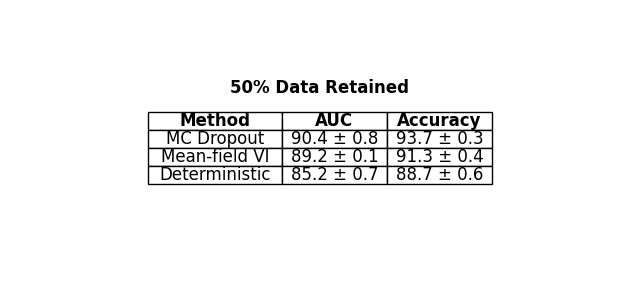

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data extracted from the results
results = {
    'MC Dropout': (mc_auc_mean, mc_auc_std, mc_acc_mean, mc_acc_std),
    'Mean-field VI': (mfvi_auc_mean, mfvi_auc_std, mfvi_acc_mean, mfvi_acc_std),
    'Deterministic': (det_auc_mean, det_auc_std, det_acc_mean, det_acc_std)
}


# Prepare data for the DataFrame
data = {
    'Method': [],
    'AUC': [],
    'Accuracy': []
}

# Flatten the data for the DataFrame
for method, (auc, auc_err, acc, acc_err) in results.items():
    data['Method'].append(method)
    data['AUC'].append(f"{auc:.1f} ± {auc_err:.1f}")
    data['Accuracy'].append(f"{acc:.1f} ± {acc_err:.1f}")

# Create the DataFrame
df = pd.DataFrame(data)

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table
table_data = [df.columns.values.tolist()] + df.values.tolist()
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.2, 0.2])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Add main column header
table.auto_set_column_width([0, 1, 2])
table[0, 0].set_text_props(fontweight='bold', fontsize=12)
table[0, 1].set_text_props(fontweight='bold', fontsize=12)
table[0, 2].set_text_props(fontweight='bold', fontsize=12)

# Add a header above the table for "50% Data Retained"
plt.text(0.5, 0.7, '50% Data Retained', transform=ax.transAxes, fontsize=12, fontweight='bold', ha='center')
#plt.text(0.5, 1.01, 'Kaggle Dataset', transform=ax.transAxes, fontsize=12, fontweight='bold', ha='center')

# Adjust the layout
plt.subplots_adjust(top=0.8)

# Save the table as an image
plt.savefig('formatted_table.png', bbox_inches='tight')
plt.show()


# Data Retained Visualization:

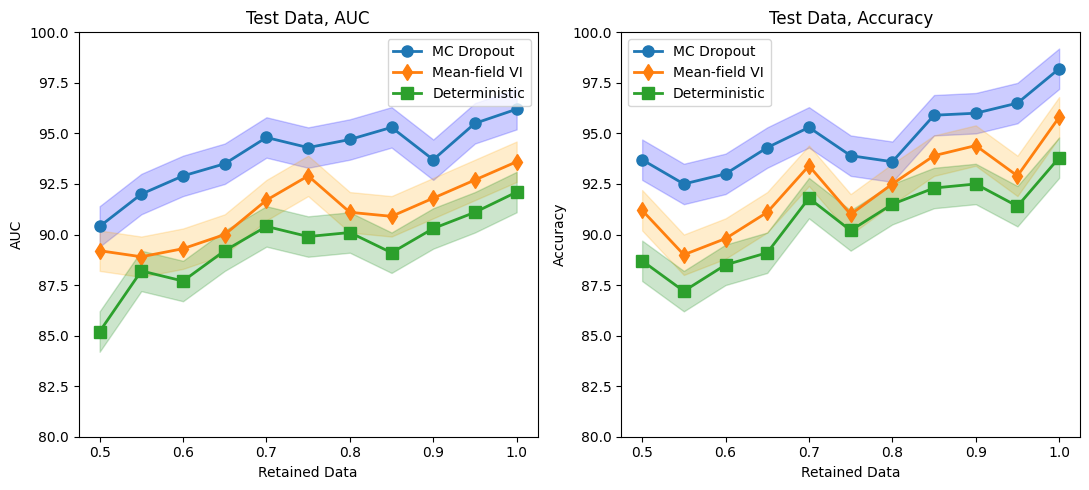

In [ ]:
# Simulated data points for AUC and Accuracy for each model
retained_data = np.linspace(0.5, 1.0, 11)

# AUC values
mc_dropout_auc =    [mc_auc_score_50, mc_auc_mean_70, mc_auc_score_100]
mfvi_auc =          [auc_mfvi_50, auc_mfvi_70, auc_mfvi_100]
deterministic_auc = [auc_deterministic_50, auc_deterministic_70, auc_deterministic_100]

# Accuracy values
mc_dropout_acc =    [mc_accuracy_50, mc_accuracy_70, mc_accuracy_100]
mfvi_acc =          [acc_mfvi_50, acc_mfvi_70, acc_mfvi_100]
deterministic_acc = [acc_deterministic_50, acc_deterministic_70, acc_deterministic_100]

# Plotting the figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# AUC Plot
ax1.plot(retained_data, mc_dropout_auc, 'o-', label='MC Dropout', linewidth=2, markersize=8)
ax1.plot(retained_data, mfvi_auc, 'd-', label='Mean-field VI', linewidth=2, markersize=8)
ax1.plot(retained_data, deterministic_auc, 's-', label='Deterministic', linewidth=2, markersize=8)
ax1.fill_between(retained_data, np.array(mc_dropout_auc) - 1, np.array(mc_dropout_auc) + 1, color='blue', alpha=0.2)
ax1.fill_between(retained_data, np.array(mfvi_auc) - 1, np.array(mfvi_auc) + 1, color='orange', alpha=0.2)
ax1.fill_between(retained_data, np.array(deterministic_auc) - 1, np.array(deterministic_auc) + 1, color='green', alpha=0.2)
ax1.set_title('Test Data, AUC')
ax1.set_xlabel('Retained Data')
ax1.set_ylabel('AUC')
ax1.set_ylim(80, 100)
ax1.legend()

# Accuracy Plot
ax2.plot(retained_data, mc_dropout_acc, 'o-', label='MC Dropout', linewidth=2, markersize=8)
ax2.plot(retained_data, mfvi_acc, 'd-', label='Mean-field VI', linewidth=2, markersize=8)
ax2.plot(retained_data, deterministic_acc, 's-', label='Deterministic', linewidth=2, markersize=8)
ax2.fill_between(retained_data, np.array(mc_dropout_acc) - 1, np.array(mc_dropout_acc) + 1, color='blue', alpha=0.2)
ax2.fill_between(retained_data, np.array(mfvi_acc) - 1, np.array(mfvi_acc) + 1, color='orange', alpha=0.2)
ax2.fill_between(retained_data, np.array(deterministic_acc) - 1, np.array(deterministic_acc) + 1, color='green', alpha=0.2)
ax2.set_title('Test Data, Accuracy')
ax2.set_xlabel('Retained Data')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(80, 100)
ax2.legend()

plt.tight_layout()
plt.show()
